In [22]:
import requests
import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchmetrics
from torchmetrics import MetricCollection, MeanMetric, Accuracy, F1Score, Precision, Recall, AUROC, ConfusionMatrix
import torch.optim as optim
from tqdm.notebook import tqdm 
import seaborn as sns

from dataclasses import dataclass, field
from typing import Dict, Tuple, Optional, Any

In [3]:
@dataclass
class CONFIG:
    # General Setting
    SEED: int = 42
    DEVICE: str = 'cuda:0'
    PRETRAINED: bool = True
    MODEL_NAME: str = 'mobilenetv3'

    # Dataset and DataLoader setting
    IMG_SIZE: int = 224
    DATASET_PATH: str = './dataset'
    SPLIT_RATIOS: Dict[str, float] = field(default_factory = lambda:{
        'train': 0.8,
        'test': 0.2,
    })
    NUM_CLASSES: int = 10
    BATCH_SIZE: int = 32  # Batch size for training
    NUM_WORKERS: int = 4  # Number of workers for DataLoader
    PIN_MEMORY: bool = True  # Pin memory for faster data transfer to GPU
    TRANSFORMS: Dict[str, Dict] = field(default_factory=lambda: {
        'train': {
            'Resize': {'height': 224, 'width': 224},
            'RandomHorizontalFlip': {'p': 0.5},
            'RandomRotation': {'degrees': 15},
            'ColorJitter': {'brightness': 0.2, 'contrast': 0.2, 'saturation': 0.2, 'hue': 0.1},
            'RandomResizedCrop': {'size': 224, 'scale': (0.8, 1.0)},
            'ToTensor': {},
            'Normalize': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
        },
        'val': {
            'Resize': {'height': 224, 'width': 224},
            'ToTensor': {},
            'Normalize': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
        },
    })

     # Training settings
    NUM_EPOCHS: int = 50
    VALIDATION_FREQ: int = 1  # Frequency (in epochs) to perform validation
    CHECKPOINT_PATH: str = './checkpoints'  # Directory to save model checkpoints
    SAVE_BEST_MODEL: bool = True  # Save only the best model
    EARLY_STOPPING: Dict[str, Any] = field(default_factory = lambda: {
        'enabled': True,
        'patience': 10,
        'min_delta': 0.001
    })

    # Optimizer settings 
    OPTIMIZER: str = 'Adam'  # Optimizer type
    OPTIMIZER_PARAMS: Dict[str, float] = field(default_factory = lambda: {
        'lr': 1e-3,  # Initial learning rate
        'weight_decay': 1e-4
    })
    ADAM_BETAS: Tuple[float, float] = (0.9, 0.999)

    # Learning rate scheduler
    SCHEDULER: str = 'CosineAnnealingLR'
    SCHEDULER_PARAMS: Dict[str, Any] = field(default_factory = lambda: {
        'T_max': 50,
        'eta_min': 1e-6
    })

    # Loss function
    LOSS_FN: str = 'CrossEntropyLoss'
    LOSS_PARAMS: Dict[str, Any] = field(default_factory=dict)

    # Logging and monitoring
    OUTPUT_DIR = "./output"
    LOG_FREQ: int = 100
    METRIC_TO_MONITOR: str = 'top1_acc'
    MONITOR_MODE: str = 'max'

    def __post_init__(self):
        # Validate parameters
        if not isinstance(self.DATASET_PATH, str) or not self.DATASET_PATH:
            raise ValueError("DATASET_PATH must be a non-empty string")
        if self.IMG_SIZE <= 0:
            raise ValueError("IMG_SIZE must be positive")
        if self.BATCH_SIZE <= 0:
            raise ValueError("BATCH_SIZE must be positive")
        if abs(sum(self.SPLIT_RATIOS.values()) - 1.0) > 1e-6:
            raise ValueError("SPLIT_RATIOS must sum to 1.0")
        if self.NUM_EPOCHS <= 0:
            raise ValueError("NUM_EPOCHS must be positive")
        # Update SCHEDULER_PARAMS['T_max'] to match NUM_EPOCHS
        if self.SCHEDULER == 'CosineAnnealingLR':
            object.__setattr__(self, 'SCHEDULER_PARAMS', {
                **self.SCHEDULER_PARAMS,
                'T_max': self.NUM_EPOCHS
            })
    

## Dataset and DataLoader setting

In [25]:
config = CONFIG()
config.DATASET_PATH = 'data/dataset-resized'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees = 15),
        transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

}

config.TRANSFORMS = data_transforms
config.NUM_EPOCHS = 50


In [38]:
torch.manual_seed(config.SEED)
full_dataset = ImageFolder(config.DATASET_PATH, transform = None)

config.NUM_CLASSES = len(full_dataset.classes)

train_size = int(config.SPLIT_RATIOS['train'] * len(full_dataset))
test_size  = len(full_dataset) - train_size

# Create separate datasets with appropriate transforms
train_dataset = ImageFolder(config.DATASET_PATH, transform = config.TRANSFORMS['train'])
test_dataset = ImageFolder(config.DATASET_PATH, transform = config.TRANSFORMS['test'])

# Randomly split indices instead of dataset directly
indices = torch.randperm(len(full_dataset)).tolist()
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

# Print dataset shapes
print('Train dataset shape: ', len(train_dataset))
print('Test dataset shape: ', len(test_dataset))

Train dataset shape:  2026
Test dataset shape:  507


In [39]:
label_names = full_dataset.classes
label_counts = Counter([label_names[labels] for _, labels in full_dataset])
label_counts

Counter({'paper': 594,
         'glass': 501,
         'plastic': 482,
         'metal': 410,
         'cardboard': 403,
         'trash': 143})

In [40]:
label_counts.items()

dict_items([('cardboard', 403), ('glass', 501), ('metal', 410), ('paper', 594), ('plastic', 482), ('trash', 143)])

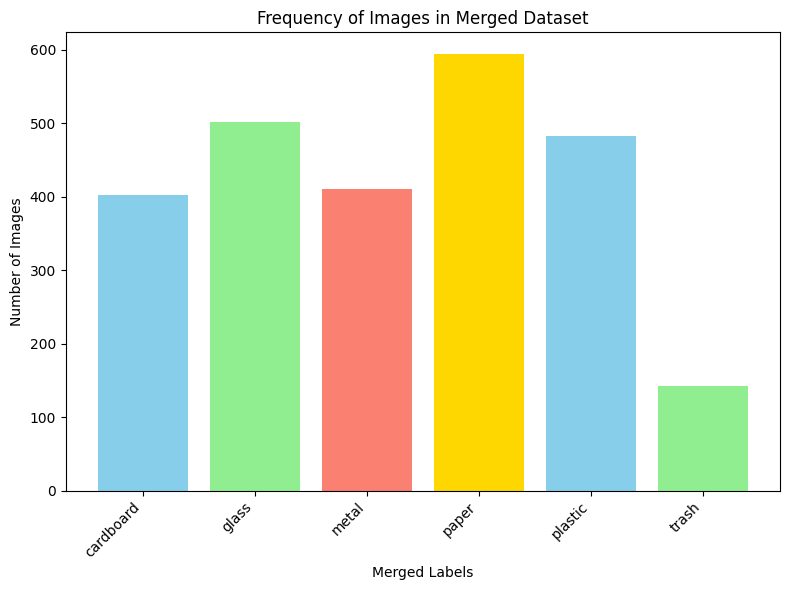

cardboard: 403 images
glass: 501 images
metal: 410 images
paper: 594 images
plastic: 482 images
trash: 143 images


In [41]:
label_names = full_dataset.classes
label_counts = Counter([label_names[labels] for _, labels in full_dataset])

# Plot the frequency
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.xlabel("Merged Labels")
plt.ylabel("Number of Images")
plt.title("Frequency of Images in Merged Dataset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

for label, counts in label_counts.items():
    print(f'{label}: {counts} images')

In [42]:
total_weight = sum(label_counts.values())
class_weights = [total_weight / label_counts[i] for i in label_counts.keys()]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(config.DEVICE)
class_weights_tensor


tensor([ 6.2854,  5.0559,  6.1780,  4.2643,  5.2552, 17.7133], device='cuda:0')

In [43]:
train_loader = DataLoader(
    train_dataset,
    config.BATCH_SIZE,
    shuffle = True,
    num_workers = config.NUM_WORKERS,
    pin_memory = config.PIN_MEMORY
)

test_loader = DataLoader(
    test_dataset,
    config.BATCH_SIZE,
    shuffle = True,
    num_workers = config.NUM_WORKERS,
    pin_memory = config.PIN_MEMORY
)

Display images

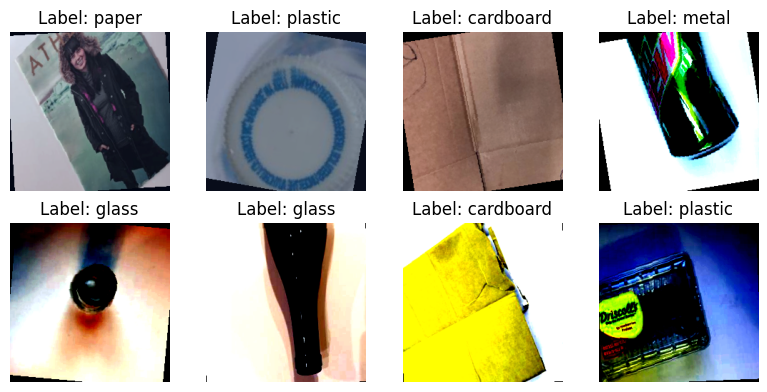

In [44]:
def denormalize(image, mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)):
    """
    Denormalize a normalized image tensor for visualization.
    
    Args:
        image (torch.Tensor): Normalized image tensor (C, H, W)
        mean (tuple): Mean used for normalization
        std (tuple): Standard deviation used for normalization
    
    Returns:
        torch.Tensor: Denormalized image tensor
    """
    img = image.clone()  # Avoid modifying the original tensor
    for i in range(3):  # Apply denormalization per channel
        img[i] = img[i] * std[i] + mean[i]
    return img.clamp(0, 1)  # Ensure pixel values are in [0, 1]


first_batch = next(iter(train_loader))  # Assumes dataloader is defined
images, labels = first_batch

# Plotting
with torch.no_grad():  # No gradients for visualization
    batch_size = images.shape[0]
    fig, axes = plt.subplots(2, 4, figsize=(4 * 2, 4))
    axes = axes.flatten()

    # Denormalize the entire batch at once
    images_denorm = denormalize(images,
                                mean = [0.485, 0.456, 0.406],
                                std = [0.229, 0.224, 0.225]).cpu()  # Move to CPU for plotting

    # Plot each image
    for i in range(8):
        img = images_denorm[i].permute(1, 2, 0).numpy()  # Convert to (H, W, C)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label_names[labels[i].item()]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


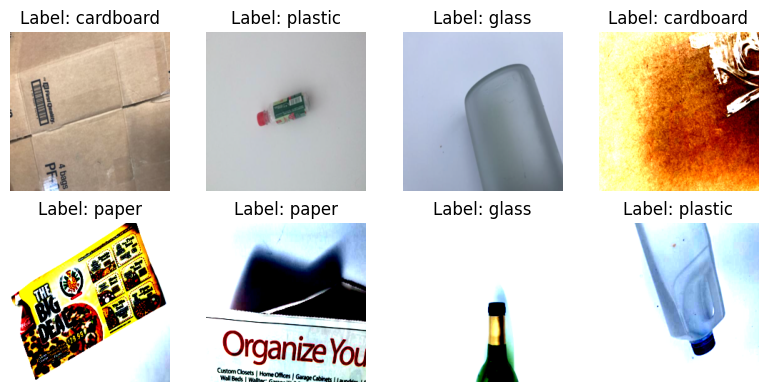

In [50]:
first_batch = next(iter(test_loader))  # Assumes dataloader is defined
images, labels = first_batch

# Plotting
with torch.no_grad():  # No gradients for visualization
    batch_size = images.shape[0]
    fig, axes = plt.subplots(2, 4, figsize=(4 * 2, 4))
    axes = axes.flatten()

    # Denormalize the entire batch at once
    images_denorm = denormalize(images,
                                mean = [0.485, 0.456, 0.406],
                                std = [0.229, 0.224, 0.225]).cpu()  # Move to CPU for plotting

    # Plot each image
    for i in range(8):
        img = images_denorm[i].permute(1, 2, 0).numpy()  # Convert to (H, W, C)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label_names[labels[i].item()]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


## Declaring the models

In [64]:
import torchvision.models as models

# Load the MobileNetV3_Small model
model = models.mobilenet_v3_small(pretrained=False)

# Modify the classifier to match the number of our output classes
num_classes = len(label_names)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

model = model.to(config.DEVICE)

print("MobileNetV3_Small model loaded and classifier modified.")


MobileNetV3_Small model loaded and classifier modified.


/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [65]:
# Function of supervised training
def train_one_epoch(config, model, train_loader, criterion, optimizer, 
                    scaler = None, scheduler = None):
    """
    Trains the model for one epoch and returns the metrics.
    Uses torchmetrics for robust metric calculation.

    Note: if you turn prob_ratio = 0, the mixup and cutmix augmentation is turn off 
    """
    model.train()
    # Intialize metrics

    metrics = MetricCollection({
        'acc': torchmetrics.Accuracy(task = "multiclass", 
                                     num_classes = config.NUM_CLASSES,
                                    average='micro'),
        'loss': MeanMetric()  # Added for consistency, but not used in pretraining
    }).to(config.DEVICE)


    # Define progress bar only for rank 0
    progress_bar = tqdm(train_loader, desc=f"Training", leave=False)

    for idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(config.DEVICE), labels.to(config.DEVICE)
        
        optimizer.zero_grad(set_to_none = True)
        
        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # Step scheduler (per batch)
        if scheduler:
            scheduler.step()
            
        # Update torchmetrics
        metrics["loss"].update(loss.item())
        metrics["acc"].update(outputs, labels)

        if idx % config.LOG_FREQ == 0:
            progress_bar.set_postfix({
                'loss': metrics["loss"].compute().item(),
                'acc': metrics["acc"].compute().item()
            })

    final_metrics = metrics.compute()        
    # Reset metrics for the next epoch
    metrics.reset()

    return final_metrics


In [66]:
# Function of supervised training
def evaluate(config, model, data_loader):
    """
    Trains the model for one epoch and returns the metrics.
    Uses torchmetrics for robust metric calculation.

    Note: if you turn prob_ratio = 0, the mixup and cutmix augmentation is turn off 
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()
    metrics = MetricCollection({
        'top1_acc': Accuracy(task="multiclass", num_classes=config.NUM_CLASSES, top_k=1),
        'precision': Precision(task="multiclass", num_classes=config.NUM_CLASSES, average='macro'),
        'f1_score': F1Score(task="multiclass", num_classes=config.NUM_CLASSES, average='weighted'),
        'precision': Precision(task="multiclass", num_classes=config.NUM_CLASSES, average='weighted'),
        'recall': Recall(task="multiclass", num_classes=config.NUM_CLASSES, average='weighted'),
        'auc_roc': AUROC(task="multiclass", num_classes=config.NUM_CLASSES, average='weighted'),
        'loss': MeanMetric()
    }).to(config.DEVICE)
    confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=config.NUM_CLASSES).to(config.DEVICE)

    progress_bar = tqdm(data_loader, desc="Evaluation", leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(config.DEVICE), labels.to(config.DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            metrics["loss"].update(loss.item())
            metrics["top1_acc"].update(outputs, labels)
            metrics["f1_score"].update(outputs, labels)
            metrics["precision"].update(outputs, labels)
            metrics["recall"].update(outputs, labels)
            metrics["auc_roc"].update(outputs, labels)
            confusion_matrix.update(outputs, labels)

            progress_bar.set_postfix({
                'loss': metrics["loss"].compute().item(),
                'top1_acc': metrics["top1_acc"].compute().item()
            })

    final_metrics = metrics.compute()
    final_metrics['confusion_matrix'] = confusion_matrix.compute().cpu().numpy()
    metrics.reset()
    confusion_matrix.reset()
    return final_metrics



In [67]:
optimizer_params = config.OPTIMIZER_PARAMS.copy()
if config.OPTIMIZER == 'Adam':
    optimizer = optim.Adam(
        model.parameters(),
        **optimizer_params,
        betas=config.ADAM_BETAS
    )
else:
    raise ValueError(f"Unsupported optimizer: {config.OPTIMIZER}")

# Initialize scheduler
if config.SCHEDULER == 'CosineAnnealingLR':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        **config.SCHEDULER_PARAMS
    )
else:
    raise ValueError(f"Unsupported scheduler: {config.SCHEDULER}")

config.LOSS_PARAMS = {
    "weight": class_weights_tensor,
    "label_smoothing": 0.1
}
if config.LOSS_FN == 'CrossEntropyLoss':
    loss_fn = nn.CrossEntropyLoss(**config.LOSS_PARAMS)
else:
    raise ValueError(f"Unsupported scheduler: {config.LOSS_FN}")

# Initialize mixed precision scaler
loss_scaler = torch.cuda.amp.GradScaler() if config.DEVICE == 'cuda' else None

In [68]:
# Initialize early stopping
best_metric = float('-inf') if config.MONITOR_MODE == 'max' else float('inf')
patience_counter = 0
best_model_path = os.path.join(config.CHECKPOINT_PATH, 'best_model_v2.pth')

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(0, config.NUM_EPOCHS):
    train_metrics = train_one_epoch(config, model, train_loader, loss_fn, optimizer, 
                                    loss_scaler,scheduler )
    train_loss_list.append(train_metrics['loss'].item())
    train_acc_list.append(train_metrics['acc'].item())
    
    eval_metrics = evaluate(config, model, test_loader)
    val_loss_list.append(eval_metrics['loss'].item())
    val_acc_list.append(eval_metrics['top1_acc'].item())

    print(f"Epoch {epoch + 1}: Train Loss = {train_metrics['loss']:.4f} | Train_Acc = {train_metrics['acc'] * 100:.2f}%")
    print(f"Epoch {epoch + 1}: Eval Loss = {eval_metrics['loss']:.4f}, Top-1 Acc = {eval_metrics['top1_acc'] * 100:.2f}%")

    # Save best model
    current_metric = eval_metrics[config.METRIC_TO_MONITOR]
    if config.SAVE_BEST_MODEL:
        if (config.MONITOR_MODE == 'max' and current_metric > best_metric) or \
           (config.MONITOR_MODE == 'min' and current_metric < best_metric):
            best_metric = current_metric
            os.makedirs(config.CHECKPOINT_PATH, exist_ok=True)
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model at epoch {epoch + 1} with {config.METRIC_TO_MONITOR}: {best_metric:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1

    # Early stopping
    if config.EARLY_STOPPING['enabled'] and patience_counter >= config.EARLY_STOPPING['patience']:
        print(f"Early stopping triggered after {patience_counter} epochs without improvement")
        break
        

    


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1: Train Loss = 1.7115 | Train_Acc = 29.37%
Epoch 1: Eval Loss = 1.8029, Top-1 Acc = 21.10%
Saved best model at epoch 1 with top1_acc: 0.2110


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2: Train Loss = 1.6462 | Train_Acc = 36.38%
Epoch 2: Eval Loss = 1.7923, Top-1 Acc = 21.10%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3: Train Loss = 1.5871 | Train_Acc = 41.56%
Epoch 3: Eval Loss = 1.8157, Top-1 Acc = 21.10%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4: Train Loss = 1.5747 | Train_Acc = 43.24%
Epoch 4: Eval Loss = 1.7915, Top-1 Acc = 21.10%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5: Train Loss = 1.5535 | Train_Acc = 43.68%
Epoch 5: Eval Loss = 1.8390, Top-1 Acc = 5.92%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6: Train Loss = 1.5101 | Train_Acc = 44.87%
Epoch 6: Eval Loss = 1.7985, Top-1 Acc = 6.51%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7: Train Loss = 1.5005 | Train_Acc = 47.19%
Epoch 7: Eval Loss = 1.7717, Top-1 Acc = 21.10%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8: Train Loss = 1.4676 | Train_Acc = 48.22%
Epoch 8: Eval Loss = 1.6458, Top-1 Acc = 30.37%
Saved best model at epoch 8 with top1_acc: 0.3037


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9: Train Loss = 1.4465 | Train_Acc = 48.17%
Epoch 9: Eval Loss = 1.5268, Top-1 Acc = 40.83%
Saved best model at epoch 9 with top1_acc: 0.4083


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10: Train Loss = 1.4881 | Train_Acc = 48.82%
Epoch 10: Eval Loss = 1.4191, Top-1 Acc = 50.49%
Saved best model at epoch 10 with top1_acc: 0.5049


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11: Train Loss = 1.4381 | Train_Acc = 51.58%
Epoch 11: Eval Loss = 1.2556, Top-1 Acc = 56.02%
Saved best model at epoch 11 with top1_acc: 0.5602


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12: Train Loss = 1.4128 | Train_Acc = 54.24%
Epoch 12: Eval Loss = 1.3485, Top-1 Acc = 47.73%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13: Train Loss = 1.3783 | Train_Acc = 52.47%
Epoch 13: Eval Loss = 1.3312, Top-1 Acc = 52.66%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14: Train Loss = 1.3508 | Train_Acc = 56.27%
Epoch 14: Eval Loss = 1.1695, Top-1 Acc = 58.58%
Saved best model at epoch 14 with top1_acc: 0.5858


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15: Train Loss = 1.3896 | Train_Acc = 52.57%
Epoch 15: Eval Loss = 1.2362, Top-1 Acc = 56.21%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16: Train Loss = 1.3561 | Train_Acc = 55.03%
Epoch 16: Eval Loss = 1.4223, Top-1 Acc = 47.14%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17: Train Loss = 1.3555 | Train_Acc = 54.94%
Epoch 17: Eval Loss = 1.3320, Top-1 Acc = 51.48%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18: Train Loss = 1.3480 | Train_Acc = 56.07%
Epoch 18: Eval Loss = 1.1065, Top-1 Acc = 57.00%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19: Train Loss = 1.3407 | Train_Acc = 56.71%
Epoch 19: Eval Loss = 1.3177, Top-1 Acc = 50.30%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20: Train Loss = 1.3225 | Train_Acc = 57.35%
Epoch 20: Eval Loss = 1.1700, Top-1 Acc = 56.02%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21: Train Loss = 1.3257 | Train_Acc = 56.52%
Epoch 21: Eval Loss = 1.0841, Top-1 Acc = 61.34%
Saved best model at epoch 21 with top1_acc: 0.6134


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22: Train Loss = 1.3031 | Train_Acc = 59.33%
Epoch 22: Eval Loss = 1.2341, Top-1 Acc = 56.02%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23: Train Loss = 1.3107 | Train_Acc = 58.24%
Epoch 23: Eval Loss = 1.0341, Top-1 Acc = 63.31%
Saved best model at epoch 23 with top1_acc: 0.6331


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24: Train Loss = 1.2995 | Train_Acc = 58.84%
Epoch 24: Eval Loss = 1.0609, Top-1 Acc = 63.12%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25: Train Loss = 1.2786 | Train_Acc = 60.91%
Epoch 25: Eval Loss = 1.1783, Top-1 Acc = 58.78%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26: Train Loss = 1.2934 | Train_Acc = 59.18%
Epoch 26: Eval Loss = 1.0061, Top-1 Acc = 66.67%
Saved best model at epoch 26 with top1_acc: 0.6667


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27: Train Loss = 1.2741 | Train_Acc = 61.40%
Epoch 27: Eval Loss = 1.2388, Top-1 Acc = 57.00%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28: Train Loss = 1.2498 | Train_Acc = 59.82%
Epoch 28: Eval Loss = 1.1397, Top-1 Acc = 57.79%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29: Train Loss = 1.3018 | Train_Acc = 60.37%
Epoch 29: Eval Loss = 1.0147, Top-1 Acc = 63.71%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30: Train Loss = 1.2816 | Train_Acc = 61.70%
Epoch 30: Eval Loss = 1.0567, Top-1 Acc = 62.13%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31: Train Loss = 1.2296 | Train_Acc = 63.28%
Epoch 31: Eval Loss = 1.1711, Top-1 Acc = 57.00%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32: Train Loss = 1.2527 | Train_Acc = 62.78%
Epoch 32: Eval Loss = 1.0234, Top-1 Acc = 64.69%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 33: Train Loss = 1.2494 | Train_Acc = 61.90%
Epoch 33: Eval Loss = 1.5362, Top-1 Acc = 40.63%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 34: Train Loss = 1.2100 | Train_Acc = 64.61%
Epoch 34: Eval Loss = 1.0195, Top-1 Acc = 64.50%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 35: Train Loss = 1.2465 | Train_Acc = 61.40%
Epoch 35: Eval Loss = 0.9813, Top-1 Acc = 63.51%


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 36: Train Loss = 1.2084 | Train_Acc = 63.62%
Epoch 36: Eval Loss = 1.4349, Top-1 Acc = 49.90%
Early stopping triggered after 10 epochs without improvement


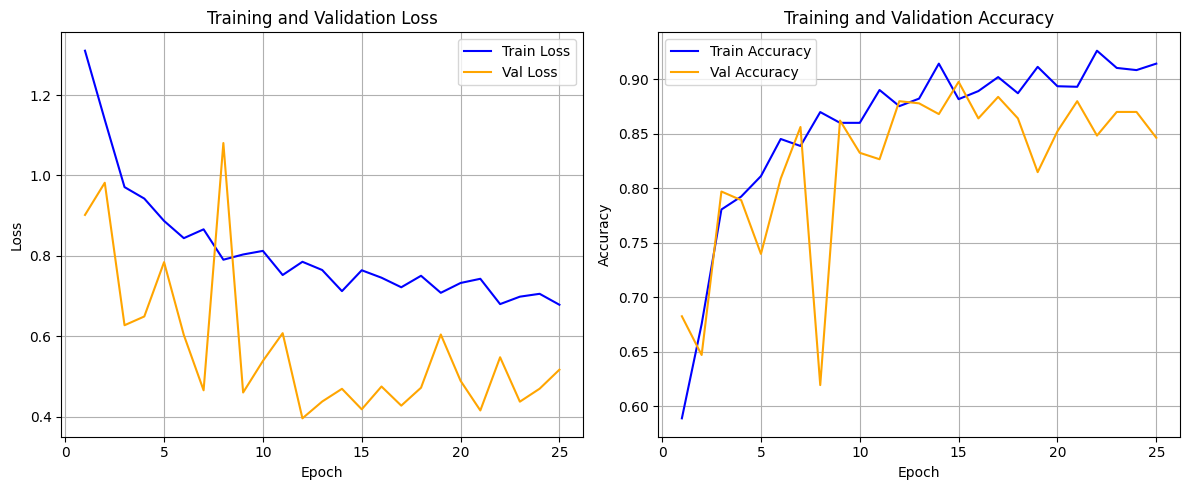

In [57]:
# Plot loss and accuracy
os.makedirs(config.OUTPUT_DIR, exist_ok = True)
epochs = range(1, len(train_loss_list) + 1)
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Train Loss', color='blue')
plt.plot(epochs, val_loss_list, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Train Accuracy', color='blue')
plt.plot(epochs, val_acc_list, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'training_metrics.png'))
plt.show()

### Evaluation

In [58]:
# Load the MobileNetV3_Small model
model = models.mobilenet_v3_small(pretrained=False)
best_model_path = os.path.join(config.CHECKPOINT_PATH, 'best_model.pth')

# Modify the classifier to match the number of our output classes
model.classifier[3] = nn.Linear(model.classifier[3].in_features, config.NUM_CLASSES)

model = model.to(config.DEVICE)

# Load best model for prediction
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print("Loaded best model for prediction")

model.eval()
metric = evaluate(config, model, test_loader)
print(metric)

Loaded best model for prediction


/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

{'auc_roc': tensor(0.9829, device='cuda:0'), 'f1_score': tensor(0.8988, device='cuda:0'), 'loss': tensor(0.4189, device='cuda:0'), 'precision': tensor(0.9056, device='cuda:0'), 'recall': tensor(0.8974, device='cuda:0'), 'top1_acc': tensor(0.8974, device='cuda:0'), 'confusion_matrix': array([[ 86,   0,   0,   2,   0,   1],
       [  0,  99,   4,   0,   3,   1],
       [  0,   8,  57,   0,   1,   1],
       [  0,   1,   1, 116,   0,   5],
       [  0,  14,   0,   1,  72,   4],
       [  1,   1,   2,   1,   0,  25]])}


In [60]:
metric

{'auc_roc': tensor(0.9829, device='cuda:0'),
 'f1_score': tensor(0.8988, device='cuda:0'),
 'loss': tensor(0.4189, device='cuda:0'),
 'precision': tensor(0.9056, device='cuda:0'),
 'recall': tensor(0.8974, device='cuda:0'),
 'top1_acc': tensor(0.8974, device='cuda:0'),
 'confusion_matrix': array([[ 86,   0,   0,   2,   0,   1],
        [  0,  99,   4,   0,   3,   1],
        [  0,   8,  57,   0,   1,   1],
        [  0,   1,   1, 116,   0,   5],
        [  0,  14,   0,   1,  72,   4],
        [  1,   1,   2,   1,   0,  25]])}

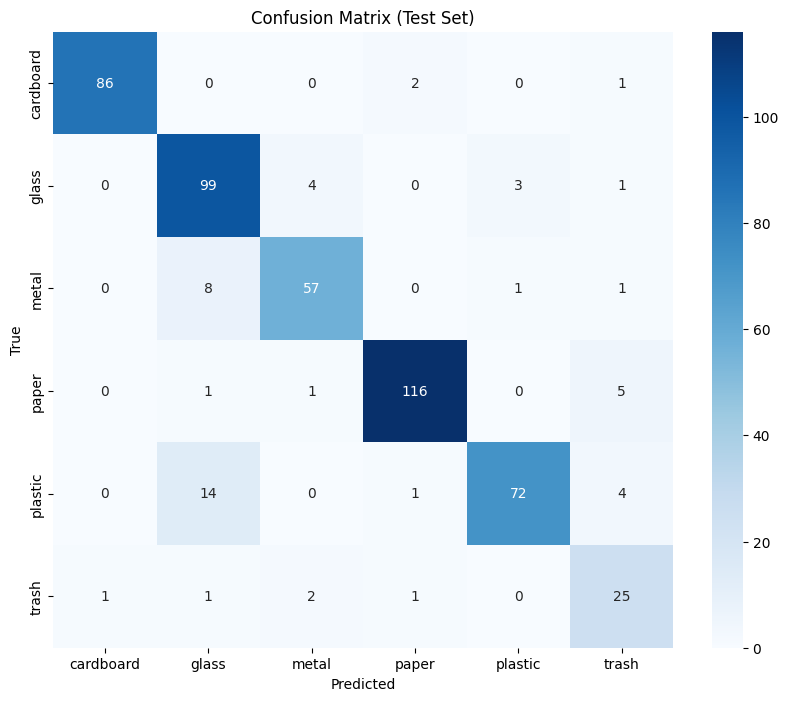

In [61]:
# Plot confusion matrix
cm = metric['confusion_matrix']
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(config.OUTPUT_DIR, 'confusion_matrix.png'))
plt.show()

  True Class: cardboard
  Predicted Class: cardboard
  Confidence: 91.17%


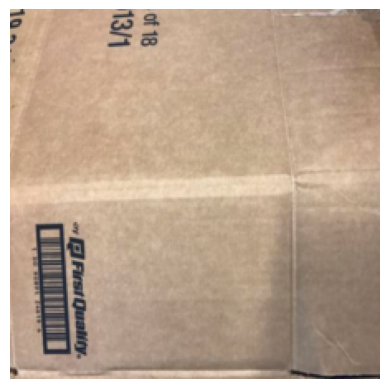

  True Class: plastic
  Predicted Class: plastic
  Confidence: 74.42%


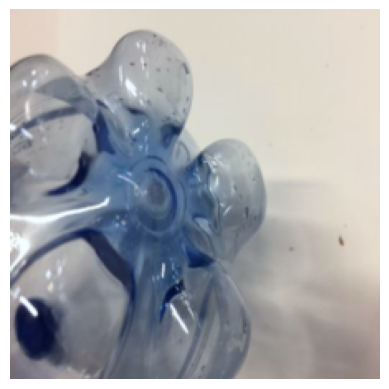

  True Class: plastic
  Predicted Class: plastic
  Confidence: 68.64%


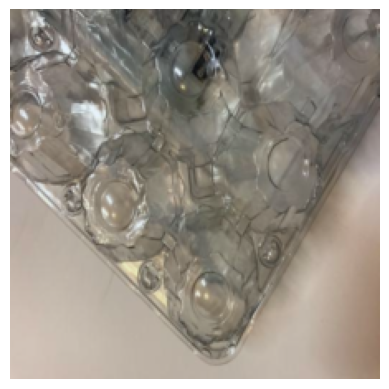

  True Class: paper
  Predicted Class: paper
  Confidence: 87.60%


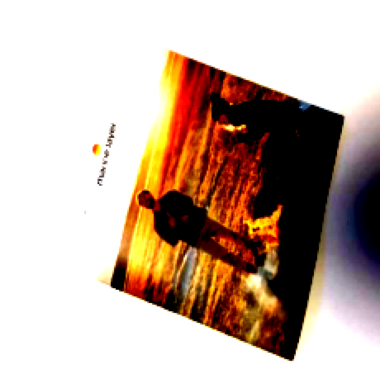

  True Class: cardboard
  Predicted Class: cardboard
  Confidence: 91.88%


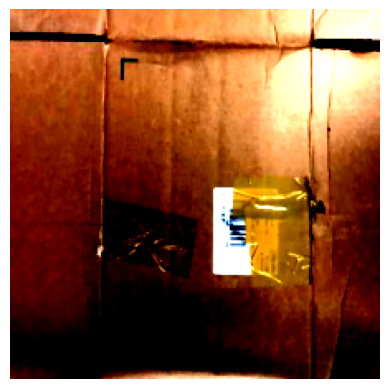

  True Class: trash
  Predicted Class: paper
  Confidence: 61.41%


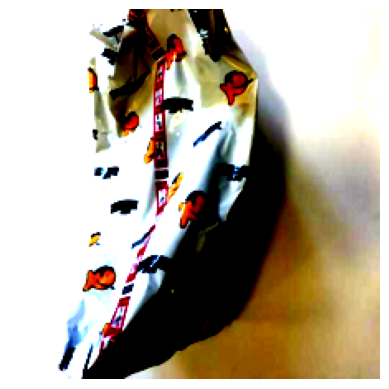

  True Class: trash
  Predicted Class: trash
  Confidence: 61.20%


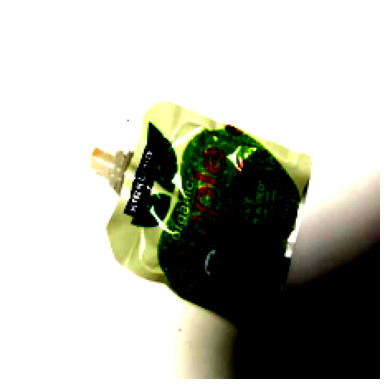

  True Class: plastic
  Predicted Class: plastic
  Confidence: 89.49%


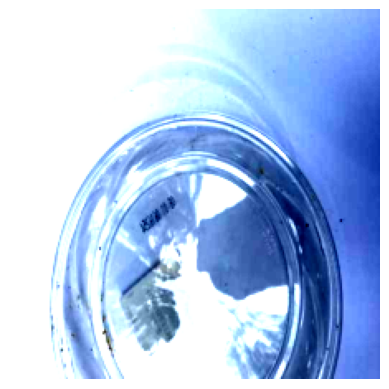

In [63]:
# Predict and display 8 images
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(config.DEVICE), labels.to(config.DEVICE)
with torch.no_grad():
    outputs = model(images)
    probabilities = torch.softmax(outputs, dim=1)
    predicted_probs, predicted = torch.max(probabilities, 1)
    

# Plot predictions
images_denorm = denormalize(
    images,
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
).cpu()

num_images_to_plot = 8
for i in range(0, num_images_to_plot):
    img = images_denorm[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    true_label = label_names[labels[i].item()]
    predict_label = label_names[predicted[i].item()]
    confidence = predicted_probs[i].item() * 100
    print(f"  True Class: {true_label}")
    print(f"  Predicted Class: {predict_label}")
    print(f"  Confidence: {confidence:.2f}%")
    plt.imshow(img)
    plt.axis('off')
    plt.show()